# SCDAA PROJECT

## Setup
Please run the cell below to install packages needed. If they are not installed suggest: !pip install <package>

In [203]:
import numpy as np
import matplotlib as plt
import pandas as pd
from numpy.polynomial.hermite_e import hermefit, hermeval
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import scipy
from scipy.stats import norm



## Question 1 - Empirical Estimation of Conditional Expectation

Calculation of the conditional expectations:

In [204]:
def coeffsForCondiExp(X,Y,hermiteOrder):
    '''
    Exercise 1.1 (i) - Use of hermefit method to estimate the coefficients (beta) used 
    in calculating conditional expectation E[Y|X] from samples X and Y
    Input: X, Y: np.ndarray (of same dimensions) of samples from two random variables X, Y
    Output: beta : coefficient for each of the samples
    '''
    beta = hermefit(X,Y,hermiteOrder)
  
    return beta

def approxCondExp(X,beta):
    '''
    Evaluate a hermiteE series at point X with coefficients beta
    Input: X: np.ndarray: samples from random variable X
           beta : np.ndarray: coefficients calculated by coeffsForCondiExp function
    Ouput: condExp: the conditional expectation E[Y|X]
    '''
    condExp =  hermeval(X, beta)

    return condExp

def plot_condExp(X,Y, Y_hat, table = False):
    '''
    Plot the conditional expectation
    Return: plot to stdout, and dataframe containing Y, Y_hat, errors, and the final rmse
    '''
    df = pd.DataFrame({'y': Y, 'y_hat':Y_hat, 'error': Y-Y_hat}, columns = ['y', 'y_hat', 'error'])
    error = Y - Y_hat
    rmse = mean_squared_error(Y, Y_hat, squared=False)

    plt.figure(figsize=(12, 6))    
    plt.subplot(121)
    sns.lineplot(x= X, y= Y, color="blue", label= 'True data')
    sns.scatterplot(x= X, y= Y_hat, color = 'red', s = 50, label= 'Fit data').set_title("Fit plot")
    
    plt.subplot(122)
    sns.scatterplot(x = X, y = error).set_title("Residual plot")
    
    plt.subplots_adjust(left=0.0)
    
    #plt.suptitle("Model rmse = " + str(round(rmse, 4)), fontsize=16)
    plt.legend()
    plt.suptitle("RMSE = " + str(round(rmse, 4)), fontsize=16)
    plt.show()

    if table == True:
        return df, rmse

### Testing of Conditional Expectation approximation

In order to test the functionality of the functions defined above, we apply them to several examples. In these examples we genereally choose an arbitrary function, and attempt to simulate it using Hermite polynomials, and then compare the outcome with a true solution.

If we take two random variables X, Y and Z, where $$ Y = f(X) + g(Z) $$. For deterministic functions $$f$$ and $$g$$, such that $$\mathbb E [|f(X)|] + \mathbb E [|g(X)|] < \infty $$, we want to calculate $$ \mathbb E [Y|X]$$.

$$ \mathbb E [Y|X] = \mathbb E [|f(X) + g(Z)|X] = f(X) + \mathbb E [g(Z)]$$

Theory stated here for clarity is taken from SCDAA lecture notes at https://www.maths.ed.ac.uk/~dsiska/scdaa_2020-21/ , Example A.40 and Theorem A.39, pp 87.

Therefore, we will first test our algorithms  for correctness, and robustness, with functions of the form described above.

##### Test of functions for an arbitrary function 
In this first example we, take an arbitrary function $$f(x) = 2x^3 + \frac{x^2}{2}$$, and $$ Z \sim Exp(0.5)$$, used to create our aribitrary simulated function Y given as $$ Y(x) = f(x) + Z $$. We assume also that the true function that we are estimating to be $$ Y^{*}(x) = f(x) + 0.5 $$. Using the functions we created in Q1, we calculate our hermite coefficientes and conditional expectation $$\mathbb{E}[Y|X]$$. The plots below show the functions as they were created, and also the results from plotting them in  a 'y=x' format so we can see if they are indeed the same. 

No handles with labels found to put in legend.


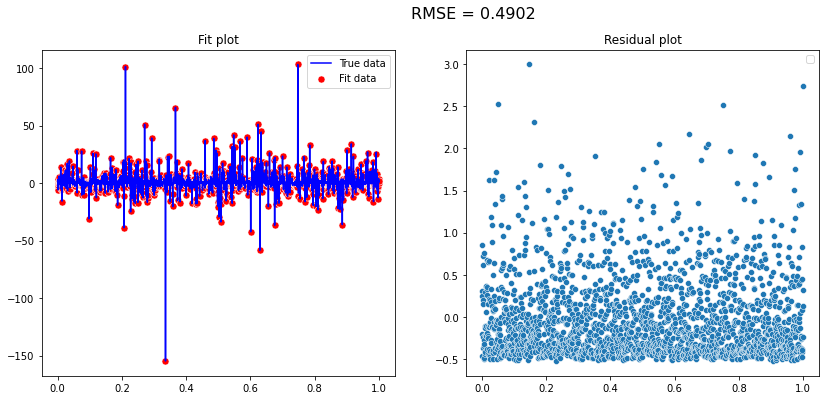

In [378]:
'''
Example 1
'''
# define functions
def f_(x):
    return 2*x ** 3 + 0.5*x**2

lambda_exp = 0.5
X_normal = np.random.normal(loc=0, scale=1, size=2000) 
Z_exp = np.random.exponential(scale=lambda_exp, size=2000) #scale = 1/lambda = mean
Y = f_(X_normal) + Z_exp
trueExp = f_(X_normal) + lambda_exp

#calc E[Y|X]
betas = coeffsForCondiExp(X_normal, Y, hermiteOrder=11)
Y_hat = approxCondExp(X_normal, betas)

# Plot results
grid = np.linspace(0,1,2000)
plot_condExp(grid,Y, Y_hat, table = True) 
error = Y - Y_hat
rmse = mean_squared_error(Y, Y_hat, squared=False) 


As this function is very noisy in nature, the left hand plot does not show the similarity between simulations and true functions especially clearly. Therefore in the plots below, we plot the two traces with an offset applied to the simulated function to distinguish it from the true values, and then plot them against one another (as y=x) so we can very easily see how good a match they are.

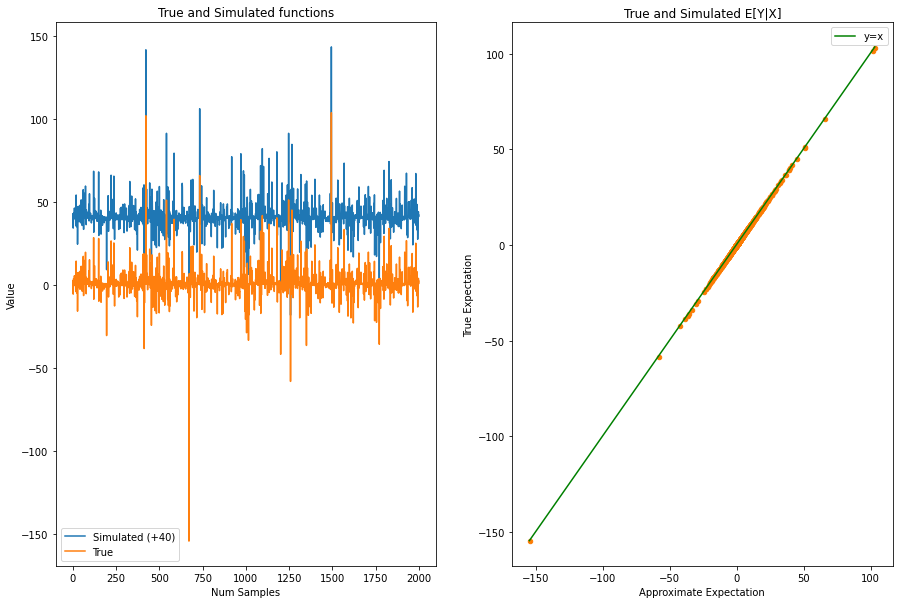

In [404]:
# Plotting using matplotlib
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_figheight(10)
fig.set_figwidth(15)

ax1.plot(Y+ 40) # could use p.5*max(trueExp) as offset? 
ax1.plot(trueExp)
ax1.set_title('True and Simulated functions')
ax1.set_xlabel('Num Samples')
ax1.set_ylabel('Value')
ax1.legend(['Simulated (+40)','True'])

ax2.scatter(trueExp, Y_hat, s=20, color = '#FC7C04')
ax2.plot(np.linspace(min(Y), max(Y)), np.linspace(min(trueExp), max(trueExp)), color = 'g')
ax2.set_title('True and Simulated E[Y|X]')
ax2.set_ylabel('True Expectation')
ax2.set_xlabel('Approximate Expectation')
ax2.legend(['y=x'])


##### Sensitivity of RMSE to Hermite orders used: 
Next, we define a function that calculates and plots the conditional expectation $$\mathbb{E}[Y|X]$$ of random variables $$ Y = 3x^2 + \frac{1}{2}Z$$, where $$Z\sim N(0,1)$$, and, $$X = 2Z $$. We use the function
 below to calculate the RMSE using the functions defined above. Then we do a short study on how well our functions approximate with varying hermite order.

In [411]:
def first_test(hermite_order,test_samples = 1000, plot = True, plot_last = True):
    '''
    Inputs: Hermite order - number of hermite polynomials
    '''
    # Set test samples, create X, Y data
    X = 3*np.random.normal(0,1,test_samples)
    Y = 3*(X**2) + .5*np.random.normal(0,1,test_samples)

    # Fit data to Hermite Coeffs
    coef = coeffsForCondiExp(X,Y,hermite_order)
    # Evaulate conditional expectation
    Y_hat = approxCondExp(X,coef)

    error = Y-Y_hat
    rmse = mean_squared_error(Y, Y_hat, squared=False)

    if plot_last == True:
        plot_condExp(X,Y, Y_hat, table = True) 
    
    if plot == True:
        print(f'rmse == {rmse}')
        plt.plot(error)
        plt.title('errors')
        plt.show()
    
    return rmse 

We call the functions defined above for the hermite order = 12, and show the goodness of fit and the residuals that are calculated for this particular case. We then run this again for other hermite orders and observe the behaviour. All plots are shown as a result of the cell below. 

No handles with labels found to put in legend.


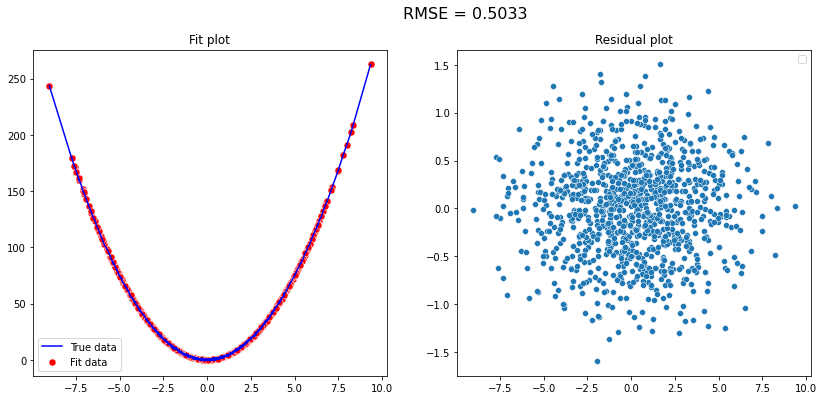

[41.64450987340132, 38.097271001113086, 0.504310410096033, 0.4964043237032985, 0.5035804901706075, 0.48809259461918525, 0.4919071151215527, 0.48922033112944063, 0.4839541169943532, 0.5024459646826266, 0.5015484794627758, 0.4917470970144423, 0.5032762325501771]


Text(0.5, 1.0, 'RMSE plots with hermite order increasing')

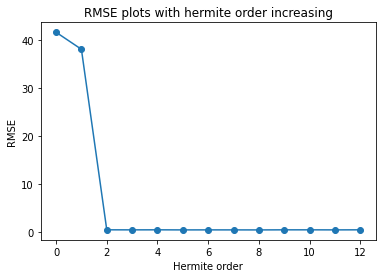

In [412]:
hermite_order = 12
rmse = []
for sample in range(hermite_order +1):
    # Code runs for each hermite order up to max (12), but only shows plots for final order.
    if sample == hermite_order:
        plot_last = True
    else:
        plot_last = False
    rmse.append(first_test(sample, plot = False, plot_last= plot_last))
print(rmse)

plt.scatter(list(range(hermite_order+1)), rmse)
plt.xlabel('Hermite order')
plt.ylabel('RMSE')

sns.lineplot(x = list(range(hermite_order+1)) , y = rmse).set_title('RMSE plots with hermite order increasing') 

Lastly, we use the following example where use $$X$$ as a linear grid and $$Z\sim N(0,1)$$, and $$Y = X + Z $$ as before. We also proceed to scan this over hermite orders as a further test.

No handles with labels found to put in legend.


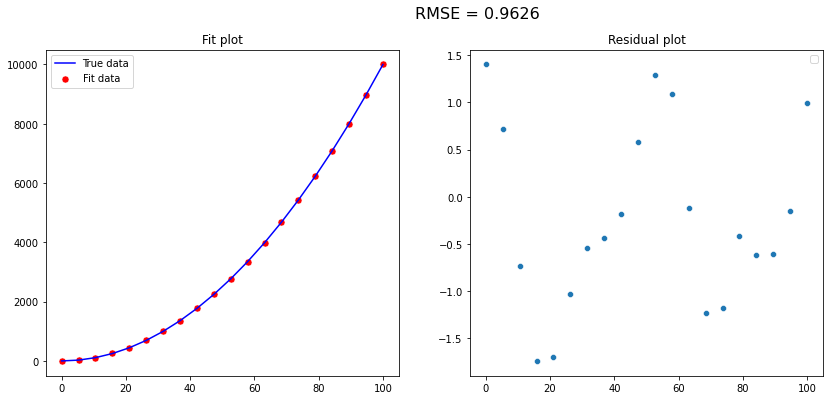

Text(0.5, 1.0, 'Residual plot')

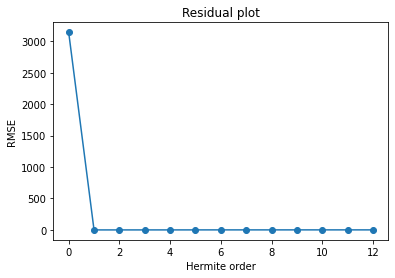

In [439]:
samples = 20
last_value = 100 
grid = np.linspace(0, last_value, samples)
X = np.linspace(0, last_value, samples)**2
Z = np.random.normal(0,1,samples) 
Y = X + Z 

# Fit data to Hermite Coeffs
coef = coeffsForCondiExp(X,Y,12)
# Evaulate conditional expectation
Y_hat = approxCondExp(X,coef)
# Calculate errors
error = Y_hat - X

plot_condExp(grid,X, Y_hat, table = False)

hermite_order = 12
rmse = np.empty(hermite_order+1) # added this for you <3 or it doesnt run!
for i in range(hermite_order + 1 ):
    coef = coeffsForCondiExp(X,Y,i)# Fit data to Hermite Coeffs
    Y_hat = approxCondExp(X,coef)# Evaulate conditional expectation
    rmse[i] = mean_squared_error(X, Y_hat, squared=False)

plt.scatter(list(range(hermite_order+1)), rmse)
plt.title('RMSE plots with hermite order increasing')
plt.xlabel('Hermite order')
plt.ylabel('RMSE')
sns.lineplot(x = list(range(hermite_order+1)) , y = rmse).set_title("Residual plot") 

##### Summary

We initially show that our function is correct by testing it on a noisy function that contains multiple distributions, and observe that a good fit is found between the simulated and true data. We obtain RMSE of 0.49 here, along with a good fit indicating that the functions are correct. To further test we scan through many hermite orders for two separate functions given above. We obtain RMSE values of 0.50 and 0.79 respectively. 


## Question 2

We define first the simple function to calculate the Black and Scholes price to verify our solution to the BSDE. `BSM_price` and `BSM_delta` are the Black Scholes model calculated price, and the assiciated greek Delta.
Parameters:
- `S_0` is the initial price at time `t=0`
- `T` - maturity time
- `K` - strike price of call option
- `r` and `sigma` are the interest rate and volatility respectively

In [299]:
'''Black Scholes model
'''
def d1(S,K,T,r,sigma):
    return (np.log(S/K)+(r+sigma**2/2)*T)/sigma* np.sqrt(T)
def d2(S,K,T,r,sigma):
    return d1(S,K,T,r,sigma)-sigma* np.sqrt(T)

def black_scholes_calc(S_0,K,T,r,sigma):
    BSM_price = S_0 * norm.cdf(d1(S_0,K,T,r,sigma)) - K*np.exp(-r*T) * norm.cdf(d2(S_0,K,T,r,sigma))
    # print('BSM price ==', BSM_price)
    BSM_delta = np.exp(-r*T)* norm.cdf(d1(S_0,K,T,r,sigma))
    #BSM_delta = norm.cdf(d1(S_0,K,T,r,sigma))
    # print('BSM delta ==', delta)

    return BSM_price, BSM_delta

Function to calculate the solution to the BSDE:

In [451]:
def BSDE_BSM2(N_mc, N, T, S_0, r, sigma, mu, K,hermite_order = 10, plot=True):

    dt = T/(N-1)
    time_steps = np.linspace(0,T,N, endpoint=True) # time_steps 

    # ===== Generate sample paths for GBm ================ #  
    dW = np.sqrt(dt) * np.random.randn(N_mc,N-1)
    W_paths = np.zeros((N_mc, N))
    W_paths[:, 1:] = np.cumsum(dW, axis=1)
 
    S_values = np.zeros([N_mc,N])
    S_values[:,0] = S_0

    for i in range(1,len(time_steps)):
        #S_values[:,i] = S_values[:,i-1]* np.exp((mu - sigma**2 /2 )* dt + sigma * dW[:,i])
        S_values[:,i] = S_0* np.exp((mu - sigma**2 /2)* time_steps[i] + sigma * W_paths[:,i])
        
    #===== Solves the BSDE ======
    Y = np.zeros([N_mc,N]) # initiate Y(2dim)
    Z = np.zeros([N_mc,N])

    # Terminal value
    Y_N = np.zeros(N_mc) # initiate last step of Y (Y_N) as zero column
    S_T = S_values[:,-1]  # final steps of each S_values in a column
    
    for i in range(N_mc):
        Y_N[i] = np.max([S_T[i] - K, 0]) #call option payoff

    Y[:,-1] = Y_N #terminal value (payoff of the option)

    for i in range(N-2,-1,-1):
        # get coeffs for Z
        coef_Z = coeffsForCondiExp(S_values[:,i],Y[:,i+1] * (W_paths[:,i+1]-W_paths[:,i]),hermite_order)     
        # Calc Z
        Z_hat = approxCondExp(S_values[:,i],coef_Z) * (1/dt)
        Z[:,i] = Z_hat

        g = r * Y[:,i+1] + (1/sigma) * (mu-r) * Z[:,i]

        # get coeffs for Y
        coef_Y =  coeffsForCondiExp(S_values[:,i],Y[:,i+1] - g * dt,hermite_order)
        # Calc Y
        Y_hat = approxCondExp(S_values[:,i],coef_Y)
        Y[:,i] = Y_hat


    if plot == True:
        
        plt.figure(figsize=(12, 6))    
        plt.subplot(121)
        plt.plot(time_steps, S_values[0:50,:].T) #plot stock price simulation
            
        plt.subplot(122)
        plt.plot(time_steps, Y[0:50,:].T)
        
        plt.subplots_adjust(left=0.0)
        plt.show()

    BSM_price, BSM_delta = black_scholes_calc(S_0,K,T,r,sigma)

    return Y[0,0], Y, BSM_price, BSM_delta, Z #, W_paths, dW

Setup Parameters for the BSDE Calculation:

In [284]:
# Setup Parameters
N_mc = 5000# Number of simulations
N = 500 # Number of timesteps in each trajectory
T = 1 # maturity time
S_0,r,sigma,mu, K = 100, 0.02, 0.2, 0.05, 95 


Calculation of the BSDE Solution and comparison to the Black Scholes calculation, along with the error in the calculation:

/shared-libs/python3.7/py/lib/python3.7/site-packages/numpy/polynomial/hermite_e.py:1385: RankWarning: The fit may be poorly conditioned
  return pu._fit(hermevander, x, y, deg, rcond, full, w)


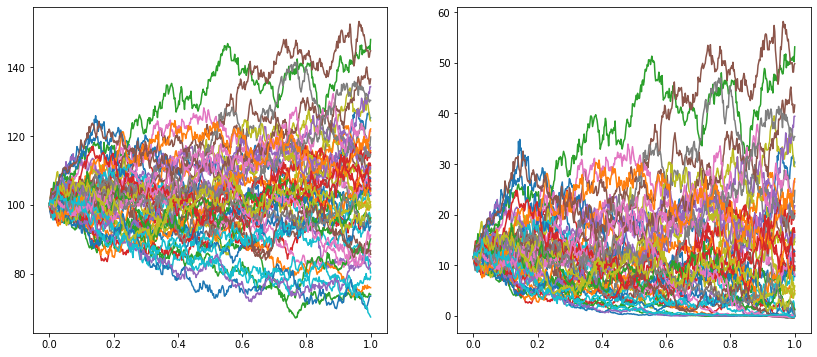

Final value of Y === 11.49759
Price from Black Scholes === 11.61377
Error BSDE vs BSM: -0.11618394630731821


In [305]:
# Calculate prices
sol_Y, path_Y, BSM_price, BSM_delta, Z_full = BSDE_BSM2(N_mc, N, T, S_0, r, sigma, mu, K,hermite_order = 20, plot=True)

print(f'Final value of Y === {round(sol_Y,5)}')
print(f'Price from Black Scholes === {round(BSM_price,5)}')

print(f'Error BSDE vs BSM: {sol_Y - BSM_price}')
# var = Z_full[0,0]/ sigma
# print(f'Compare Z[0,0] to BSM delta:{var} and {BSM_delta*S_0}')
# print(Z_full[0,0], sigma, var, BSM_delta)

# Z_full

Plots show on the left the forward paths calculated from an initial `S_0`. The plot on the right shows that using the dW calculated in function BSDE_BSM, the price that we converge on as our final solution for comparison. The final value of Y is the calculated price and the Black scholes price is consistently of the order of 1% (the values change as the code here runs so we have refrained from naming specific values). 

### Experiments for Q2
We conduct three experiments to verify the solution for Question 2.

1. Testing number of Monte Carlo Samples `N_mc` (`hermite order`, `N` timesteps = constant)
2. Testing N timesteps `N = 2,4,8,16,...,1024` (`N_mc`, `hermite_order` = constant)
3. Testing `hermite_order =1,2,3 ...,10` (`N_mc`, `N` timesteps = constant)

##### 1. Testing number of Monte Carlo Samples `N_mc` (`hermite order`, `N` timesteps = constant)

/shared-libs/python3.7/py/lib/python3.7/site-packages/numpy/polynomial/hermite_e.py:1385: RankWarning: The fit may be poorly conditioned
  return pu._fit(hermevander, x, y, deg, rcond, full, w)


[None, None, Text(0.5, 0, 'Monte Carlo samples'), Text(0, 0.5, 'Error')]

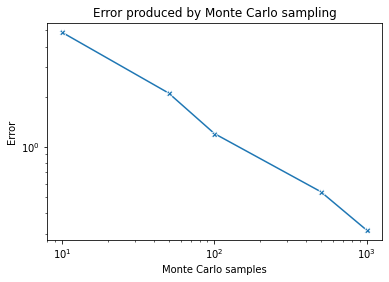

In [94]:
'''Increasing Monte carlo samples
'''
N_mc_samples = [10,50,100,500,1000] #,5000,10000]
T, N, hermite_order = 1, 2000, 10
S_0,r,sigma,mu, K = 100, 0.02, 0.2, 0.05, 95 
evaluations = 10
errors = np.zeros([evaluations,len(N_mc_samples)])
final_error = []

for i in range(len(N_mc_samples)):
    for j in range(evaluations):
        sol_Y, paths_Y, BSM_price, BSM_delta = BSDE_BSM2(N_mc_samples[i], N, T, S_0, r, sigma, mu, K, hermite_order, plot=False)
        #print(np.abs(sol_Y - BSM_price))
        errors[j,i] = np.abs(sol_Y - BSM_price)
    
    final_error.append(np.mean(errors[:,i]))

splot = sns.lineplot(x = N_mc_samples , y = final_error, marker='X')
splot.set_title("Error produced by Monte Carlo sampling")
splot.set(xscale='log', yscale = 'log',xlabel='Monte Carlo samples', ylabel='Error')

##### 2. Testing N timesteps `N = 2,4,8,16,...,1024` (`N_mc`, `hermite_order` = constant)

/shared-libs/python3.7/py/lib/python3.7/site-packages/numpy/polynomial/hermite_e.py:1385: RankWarning: The fit may be poorly conditioned
  return pu._fit(hermevander, x, y, deg, rcond, full, w)


[None, None, Text(0.5, 0, 'Number of timesteps'), Text(0, 0.5, 'Error')]

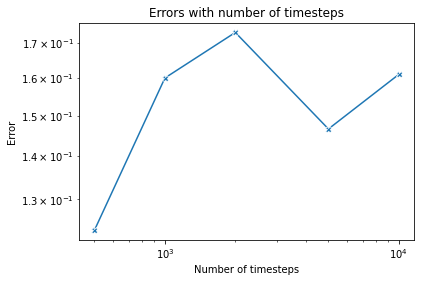

In [137]:
'''Increasing number of timesteps N
'''
N_timesteps = [500, 1000, 2000, 5000, 10000] # N_timesteps = [2**power for power in range(2,8)]
N_mc_samples = 5000
T, hermite_order = 1, 10
S_0,r,sigma,mu, K = 100, 0.02, 0.2, 0.05, 95 
evaluations = 20
errors = np.zeros([evaluations,len(N_timesteps)])
final_error_Ntimesteps = []

for i in range(len(N_timesteps)): 
    for j in range(evaluations):
        sol_Y, paths_Y, BSM_price, BSM_delta = BSDE_BSM2(N_mc_samples, N_timesteps[i], T, S_0, r, sigma, mu, K, hermite_order, plot=False)
        errors[j,i] = np.abs(sol_Y - BSM_price)
    
    final_error_Ntimesteps.append(np.mean(errors[:,i]))

splot = sns.lineplot(x = N_timesteps , y = final_error_Ntimesteps, marker='X')
splot.set_title("Errors with number of timesteps")
splot.set(xscale='log', yscale = 'log',xlabel='Number of timesteps', ylabel='Error')


##### 3. Testing `hermite_order = 1,2,3 ...,10` (`N_mc`, `N` timesteps = constant)

/shared-libs/python3.7/py/lib/python3.7/site-packages/numpy/polynomial/hermite_e.py:1385: RankWarning: The fit may be poorly conditioned
  return pu._fit(hermevander, x, y, deg, rcond, full, w)


[None, None, Text(0.5, 0, 'Hermite order'), Text(0, 0.5, 'Error')]

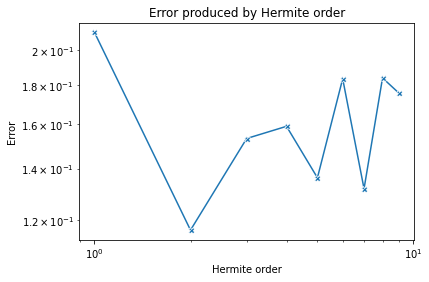

In [138]:
'''Increase Hermite Order
'''
hermite_orders = range(1,10)
T,N, N_mc_samples = 1, 2000, 5000
S_0,r,sigma,mu, K = 100, 0.02, 0.2, 0.05, 95 
evaluations = 20
errors = np.zeros([evaluations,len(hermite_orders)])
final_error_hermite = []

for i in range(len(hermite_orders)):
    for j in range(evaluations):
        sol_Y, paths_Y, BSM_price, BSM_delta = BSDE_BSM2(N_mc_samples, N, T, S_0, r, sigma, mu, K, hermite_orders[i], plot=False)
        errors[j,i] = np.abs(sol_Y - BSM_price)

    final_error_hermite.append(np.mean(errors[:,i]))

splot = sns.lineplot(x = hermite_orders , y = final_error_hermite, marker='X')
splot.set_title("Error produced by Hermite order")
splot.set(xscale='log', yscale = 'log',xlabel='Hermite order', ylabel='Error')

##### Summary for Q2
Firstly we solve the BSDE set out in the question, and we verif our solution with the standard Black and Scholes model for price of a call option and wee an agreement between the two of around 1%. Due to this process being fundamentall driven by a random process there is some variation but we felt that this is a good level of similarity. 

We conducted three more formal experiments to verify that the system behaves as we expect. The first experiment we varied the number of monte carlo (MC) samples which is expected to have a key impact on the prediction. By increasing the MC samples, we are propagating many possible payoffs throuhg our BSDE and we find that they converge toward to a single initial price at `t=0`. This happens with increasing accuracy as we increase the number of MC samples. As the number of `N_mc_samples`$$ \rightarrow \infty$$ then we will converge on the true value. In our first experiment we increase the number of MC sampls from this to this and we see precisely this trend. Errors defined as the difference between the Black scholes price and the calculated price, and this drops with approximately $$ x^{-0.6}$$. 
The second experiment shows how the behaviour changes as we increase the number of timesteps, i.e. reduce the granularity of our time grid. We maintain $$T=1$$, but divide the grid into increasing numbers of divisions. We expect to find that as the number of time steps increases that the error becomes small, but in our experiment we do not seee a clear trend. We observe some quite erratic and almost increasing errors as we increase the timesteps. 
The third experiment we vary the hermite orders that are used, ranging from 1 to 12. We expect to find that the errors aredecreasing as the hermite orders increase to some extent, however we also will begine to see 'overfitting' of the solution with high orders. Our results show that as expected, a hermite order of 1 gives a larger error, but then beynod this the behaviour is once again, reasonably erratic. 

## Question 3

In [205]:
N_time = 5000 # Number of timesteps in each trajectory
T = 1 #maturity time
dt = T / (N_time-1)
delta = 0.01#0.02
epsilon = 0.000001#1e-5
gain = float('-inf')# big negative number
time_steps = np.linspace(0,T,N_time) # time_steps

x = np.ones(N_time) 
y = np.ones(N_time)
alpha = np.zeros(N_time) #np.ones(N_time)


In [206]:

def M(t):
    return 1

def H(t):
    return 1

def C(t): 
    return 0 #for convenience to solve ODE dX_t

def D(t):
    return -1#-1

def R(t):
    return -1

def F(t):
    return 0

def final_reward(x,t):
    #return R(t) * x **2
    return R(t) * (x-5)**2

def b_(x,t,alpha):
    return H(t) * x + M(t) * alpha

def f(x,t,alpha): 
    return C(t) * x**2 + D(t) * alpha**2 +2*x*F(t)*alpha

def hamiltonian(x,y,t,alpha):
    return b_(x,t,alpha) * y + f(x,t,alpha)

def dg_by_dx(x,t):
    #return 2* R(t) * x
    return 2 * R(t) *  (x - 5)

def dHam_by_da(y,x,t, alpha):
    return M(t) * y + 2* alpha * D(t) + 2*x*F(t) 

def dHam_by_dx(x, y, t,alpha):
    return y*H(t) + 2*x*C(t) + 2*F(t)*alpha 


In [226]:
def Linear_quadratic_control(T, N, x, y, epsilon, alpha, delta, max_iterations):
    gain = float('-inf')# big negative number
    time_steps = np.linspace(0,T,N) # time_steps
    dt = T/N#(N-1)
    iteration = 1
    J_list = []
    
    for iterations in range(max_iterations):
        
        for i in range(N-1):
            x[i+1] = x[i] + dt * b_(x[i],time_steps[i],alpha[i])
            #print(sum(x))
        #backward
        y[-1] = dg_by_dx(x[-1],time_steps[-1]) #2
        for i in reversed(range(1,N)):
            y[i-1] = y[i] - dt* dHam_by_dx(x[i],y[i],time_steps[i] ,alpha[i]) 
           

        #solve for max alpha
        for i in range(N):
            alpha[i] = alpha[i] + delta * dHam_by_da(y[i],x[i],time_steps[i],alpha[i] ) 

        #calculate the gain by the integral using euler method 
        current_gain = 0
        for i in range(N):
            current_gain = current_gain + dt * f(x[i],time_steps[i],alpha[i])
        
        current_gain = current_gain + final_reward(x[N-1],time_steps[N-1])
        #print(current_gain)
        J_list.append(current_gain)

        # conditions for gain stability
        if current_gain < gain:
            print('Method Failed')
            return 0,0,0,0,0,0 
            #break
        elif gain + epsilon > current_gain:
            print("Method converged")
            return J_list,current_gain, iteration, x,y,alpha
            
            break
        else: #go to next iteration
            gain = current_gain

        iteration = iteration + 1

    


In [227]:
N_time = 5000 #20 # Number of timesteps in each trajectory
T = 1 #maturity time
dt = T / (N_time-1)
delta = 0.01#0.02
epsilon = 0.000001#1e-5
gain = float('-inf')# big negative number
time_steps = np.linspace(0,T,N_time) # time_steps
max_iterations = 300

x = np.ones(N_time) 
y = np.ones(N_time)
alpha = np.zeros(N_time)#np.ones(N_time)

J, J_actual, iteration, X, Y,alphas = Linear_quadratic_control(T, N_time, x, y, epsilon, alpha, delta, max_iterations)


Method converged


In [228]:
print(J_actual)
iteration

-1.8666290413215163


272

Text(0.5, 0, 't')

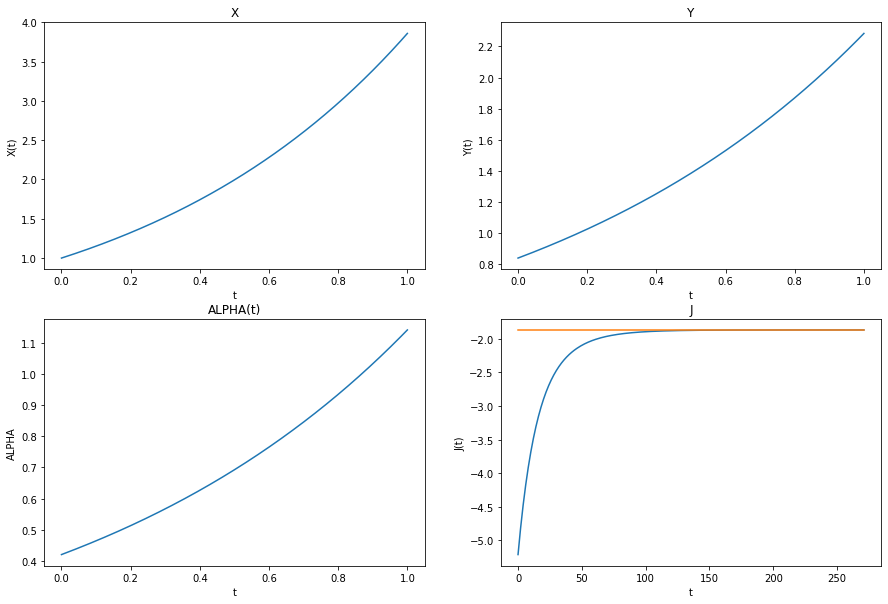

In [34]:
x = np.linspace(0,1,N_time)

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(15,10))

ax[0,0].plot(x, X)
ax[0,0].set_title('X')
ax[0,0].set_ylabel('X(t)')
ax[0,0].set_xlabel('t')
ax[0,1].plot(x, Y)
ax[0,1].set_title('Y')
ax[0,1].set_ylabel('Y(t)')
ax[0,1].set_xlabel('t')
ax[1,0].plot(x, alphas)
ax[1,0].set_title('ALPHA(t)')
ax[1,0].set_ylabel('ALPHA')
ax[1,0].set_xlabel('t')
ax[1,1].plot(np.arange(len(J)), J)
ax[1,1].plot(np.arange(len(J)), np.full((len(J)),J[-1]))
ax[1,1].set_title('J')
ax[1,1].set_ylabel('J(t)')
ax[1,1].set_xlabel('t')



To test whether our solution is correct, we compare the analytical solutions to $X$ and $Y$ to our computed solutions. The analytical solution of $X$ is:

$$X_t = e^t(\int_0^te^{-s}\alpha_s ds + x)$$

and the analytical solution of $Y$ under this setting is:

$$Y_t = e^{t-1}(10-2X_1)$$

The comparisons below show that our $X$ and $Y$ processes are correct.

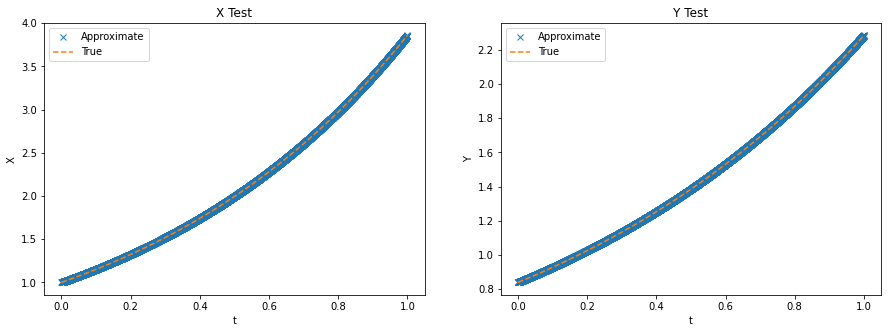

In [19]:
# test true value for X and Y
#N = 5000
X_true_ours = np.zeros(N_time)
X_true_ours[0] = 1

t = np.linspace(0, 1, N_time)
dt = 1/N_time
integral_ours = 0

#====solve for x===================
for i in range(1,N_time):
    integral_ours = integral_ours + dt/2 * (np.exp(-t[i]) * alphas[i] + np.exp(-t[i-1]) * alphas[i-1])           
    X_true_ours[i] = np.exp(t[i]) * (integral_ours + X_true_ours[0])


#====solve for y===================
Y_true_ours = np.zeros(N_time)
for i in range(N_time):
    Y_true_ours[i] = np.exp(t[i] - 1) * (10 - 2 * X[-1])


fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15,5))

ax[0].plot(t, X, 'x')
ax[0].plot(t, X_true_ours, "--")
ax[0].set_title('X Test')
ax[0].set_xlabel('t')
ax[0].set_ylabel('X')
ax[0].legend(['Approximate', 'True'])
ax[1].plot(t, Y, 'x')
ax[1].plot(t, Y_true_ours, '--')
ax[1].set_title('Y Test')
ax[1].set_xlabel('t')
ax[1].set_ylabel('Y')
ax[1].legend(['Approximate', 'True'])

Similarly, the analytical solution for $\alpha$ under this setting is simply:

$$\alpha_t = Y_t / 2$$

Again, our graph below shows our solution is correct.

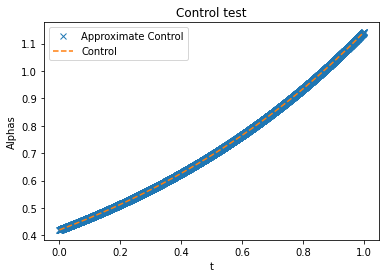

In [20]:
# under this setting the optimal control is equal to Y/2 so let's see 
plt.plot(t, alphas, "x")
plt.plot(t, Y/2, "--")
plt.title('Control test')
plt.xlabel('t')
plt.ylabel('Alphas')
plt.legend(['Approximate Control', 'Control'])

Method converged


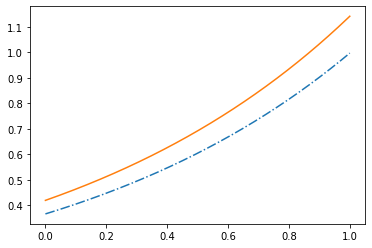

In [267]:
N_time = 5000 #20 # Number of timesteps in each trajectory
T = 1 #maturity time
dt = T / (N_time-1)
delta = 0.001#0.02
epsilon = 0.001#1e-5
gain = float('-inf')# big negative number
time_steps = np.linspace(0,T,N_time) # time_steps
max_iterations = 3000

x = np.ones(N_time) 
y = np.ones(N_time)
alpha = np.zeros(N_time)#np.ones(N_time)
J, J_actual, iteration, X, Y,alphas = Linear_quadratic_control(T, N_time, x, y, epsilon, alpha, delta, max_iterations)
alphas

#t = np.linspace(0, 1, 5000)
plt.plot(time_steps, alphas, linestyle = 'dashdot')
plt.plot(t, Y_true_ours/2)


Method converged
Method converged
Method converged


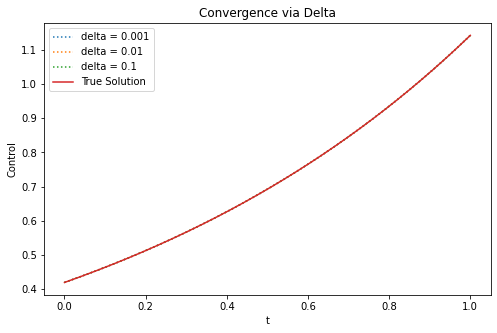

In [266]:
# testing with delta...

deltas = [0.001, 0.01, 0.1] #, 0.15, 0.2, 0.25, 0.3]
legend = []
N_time = 5000 #20 # Number of timesteps in each trajectory
T = 1 #maturity time
dt = T / (N_time -1) 
epsilon = 0.001
gain = float('-inf')# big negative number
time_steps = np.linspace(0,T,N_time) # time_steps
max_iterations = 3000

fig = plt.figure(figsize=(8,5))
for i in range(len(deltas)):

    J, J_actual, iteration, X, Y,alphas = Linear_quadratic_control(T, N_time, x, y, epsilon, alpha, deltas[i], max_iterations)
    # J_list,current_gain, iteration, x,y,alpha = def Linear_quadratic_control(T, N, x, y, epsilon, alpha, delta, max_iterations)
    if np.mean(alphas)!= 0: 
        plt.plot(time_steps, alphas, linestyle = ':')
        legend.append(f'delta = {deltas[i]}')

legend.append('True Solution')
plt.title('Convergence via Delta')
plt.plot(time_steps, Y_true_ours/2)
plt.xlabel('t')
plt.ylabel('Control')
plt.legend(legend)

In [254]:
Y_true_ours

array([0.83992026, 0.84008829, 0.84025636, ..., 2.28222671, 2.2826833 ,
       2.28313997])

In [248]:
J, J_actual, iteration, X, Y,alphas = Linear_quadratic_control(T,5000, x, y, epsilon, alpha, delta, max_iterations)
alphas

Method Failed


0

In [50]:
# test convergence for N
Ns = [4, 16, 32, 64, 128, 256, 512, 1028, 2048, 4096, 5000, 6000, 8000]
leg = []

fig = plt.figure(figsize=(10,5))
for i in range(len(Ns)):

    t = np.linspace(0, 1, Ns[i])
    J, J_actual, iteration, X, Y,alphas = Linear_quadratic_control(T, Ns[i], x, y, epsilon, alpha, delta, max_iterations)
    #test_alphas, _, _, _ = LinearQuadraticControl(T=1, N=Ns[i], x=1, epsilon=1e-5, alpha_0=np.zeros(Ns[i]), R=-1, delta=0.01)
    if Y != 0:#if converge
        plt.plot(t, alphas, linestyle = '--')
    leg.append(f'N = {Ns[i]}')

t = np.linspace(0, 1, 5000)
leg.append('True Solution')
plt.title('Convergence via N')
plt.plot(t, Y_true_ours)
plt.xlabel('t')
plt.ylabel('Control')
plt.legend(leg)

Method Failed
Method Failed
Method Failed
Method Failed
Method Failed
Method Failed
Method Failed
Method Failed
Method Failed
Method Failed


TypeError: cannot unpack non-iterable NoneType object

<Figure size 720x360 with 0 Axes>

## Question 4

In [473]:
def M(t):
    return 1

def H(t):
    return 1

def C(t): 
    return 0 #for convenience to solve ODE dX_t

def D(t):
    return -1#-1

def R(t):
    return -1

def F(t):
    return 0

def final_reward(x,t):
    #return R(t) * x **2
    return R(t) * (x-5)**2

def b_(x,t,alpha):
    return H(t) * x + M(t) * alpha

def f(x,t,alpha): 
    return C(t) * x**2 + D(t) * alpha**2 +2*x*F(t)*alpha

def hamiltonian(x,y,t,alpha):
    return b_(x,t,alpha) * y + f(x,t,alpha)

def dg_by_dx(x,t):
    #return 2* R(t) * x
    return 2 * R(t) *  (x - 5)

def dHam_by_da(y,x,t, alpha):
    return M(t) * y + 2* alpha * D(t) + 2*x*F(t) 

def dHam_by_dx(x, y, t,alpha):
    return y*H(t) + 2*x*C(t) + 2*F(t)*alpha 

def sigma(x,t,alpha):
    return 0.01#.2

In [474]:
def Stochastic_Linear_quadratic_control(T, N, x, y, epsilon, alpha, delta, max_iterations,N_mc):
    gain = float('-inf')# big negative number
    time_steps = np.linspace(0,T,N) # time_steps
    dt = T/(N-1)
    iteration = 1
    J_list = []
    dW = np.sqrt(dt) * np.random.randn(N_mc,N-1)
    W_paths = np.zeros((N_mc, N))
    W_paths[:, 1:] = np.cumsum(dW, axis=1)
 
    for iterations in range(max_iterations):   
        
        #Solve Forward SDE
        for i in range(N-1):
            x[:,i+1] = x[:,i] + dt * b_(x[:,i],time_steps[i],alpha[:,i]) + sigma(x[:,i],time_steps[i], alpha[:,i]) * dW[:,i]

        #Solve BSDE
        y[:,-1] = dg_by_dx(x[:,-1],time_steps[-1]) #2

        for i in range(N-2,-1,-1):
            # get coeffs for Z conditioning on W[t] 
            coef_Z = coeffsForCondiExp(W_paths[:,i],y[:,i+1] * (W_paths[:,i+1]-W_paths[:,i]),hermite_order)     
            # Calc Z
            Z_hat = approxCondExp(W_paths[:,i],coef_Z) * (1/dt)
            z[:,i] = Z_hat
        
            #g = dHam_by_dx(x[:,i], y[:,i+1], time_steps[i],alpha[:,i])
            g = dHam_by_dx(x[:,i+1], y[:,i+1], time_steps[i+1],alpha[:,i])

            # get coeffs for Y
            coef_Y =  coeffsForCondiExp(W_paths[:,i],y[:,i+1] - g * dt,hermite_order)
            # Calc Y
            Y_hat = approxCondExp(W_paths[:,i],coef_Y)
            y[:,i] = Y_hat

        #solve for max alpha

        for i in range(N):
            alpha[:,i] = alpha[:,i] + delta * dHam_by_da(y[:,i],x[:,i],time_steps[i],alpha[:,i] ) 

        #calculate the gain by the integral using euler method 
        current_gain = 0
        for i in range(N):
            current_gain = current_gain + dt * f(x[:,i],time_steps[i],alpha[:,i])

        current_gain = np.mean(current_gain + final_reward(x[:,N-1],time_steps[i]))
        #current_gain

        J_list.append(current_gain)

        # conditions for gain stability
        if current_gain < gain:
            print('Method Failed')
            return 0,0,0,0,0,0 
            #break
        elif gain + epsilon > current_gain:
            print("Method converged")
            return J_list,current_gain, iteration, x,y,alpha,W_paths
            
            break
        else: #go to next iteration
            gain = current_gain

        iteration = iteration + 1


In [475]:

N_time = 2000 #20 # Number of timesteps in each trajectory
T = 1 #maturity time
N_mc = 100
x = np.zeros((N_mc, N_time))
y = np.zeros((N_mc, N_time))
z = np.zeros([N_mc,N_time])
alpha = np.zeros((N_mc, N_time))
delta = 0.01#0.02
epsilon = 0.0001#1e-5
gain = float('-inf')# big negative number
max_iterations = 300

J, J_actual, iteration, X, Y,alphas,W = Stochastic_Linear_quadratic_control(T, N_time, x, y, epsilon, alpha, delta, max_iterations, N_mc)


#Stochastic_Linear_quadratic_control(T, N, x, y, epsilon, alpha, delta, max_iterations)

/shared-libs/python3.7/py/lib/python3.7/site-packages/numpy/polynomial/hermite_e.py:1385: RankWarning: The fit may be poorly conditioned
  return pu._fit(hermevander, x, y, deg, rcond, full, w)
Method converged


In [482]:
print(iteration)
J_actual
alphas
X
print("Y==",Y)
print("alphas ==", alphas)
print("J ==", J)
X
print("J actual === ",J_actual)

198
Y== [[1.8392857  1.84032284 1.84115313 ... 5.0332729  5.03642156 5.03630854]
 [1.8392857  1.84029588 1.84147994 ... 5.02594197 5.02790125 5.02722846]
 [1.8392857  1.84031554 1.84060261 ... 5.01377603 5.0162728  5.01493758]
 ...
 [1.8392857  1.8403603  1.84089715 ... 4.96740645 4.97004166 4.97594341]
 [1.8392857  1.84012188 1.84112583 ... 4.98957788 4.99259589 4.99485989]
 [1.8392857  1.83996555 1.84135298 ... 4.9928213  4.99515361 4.99502541]]
alphas == [[0.9190617  0.91957982 0.9199948  ... 2.5150072  2.51657913 2.5164599 ]
 [0.9190617  0.91956637 0.92015773 ... 2.51134425 2.51232419 2.511945  ]
 [0.9190617  0.91957617 0.91972033 ... 2.50530792 2.50655536 2.50582851]
 ...
 [0.9190617  0.91959849 0.91986718 ... 2.48215429 2.48347018 2.48649741]
 [0.9190617  0.91947962 0.91998119 ... 2.49320146 2.4947074  2.49585437]
 [0.9190617  0.91940168 0.92009443 ... 2.49481218 2.49597817 2.49588209]]
J == [-24.97933985872623, -24.00334867921786, -23.092645202700012, -22.2425606641748, -21.4487

Text(0.5, 0, 't')

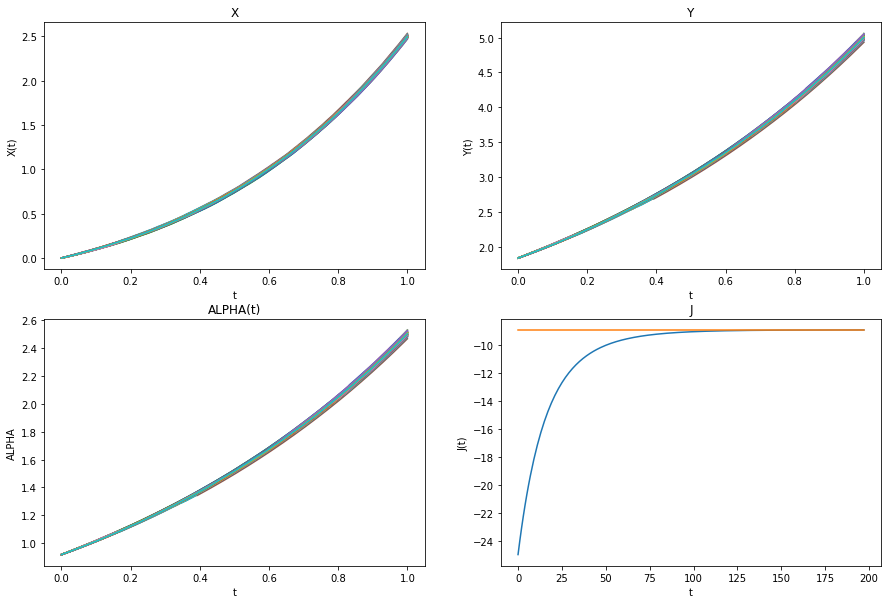

In [486]:
x = np.linspace(0,1,2000)

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(15,10))
for i in range(50):
    ax[0,0].plot(x, X[i])
    ax[0,1].plot(x, Y[i])
    ax[1,0].plot(x, alphas[i])

ax[0,1].set_title('Y')
ax[0,1].set_ylabel('Y(t)')
ax[0,1].set_xlabel('t')
ax[0,0].set_title('X')
ax[0,0].set_ylabel('X(t)')
ax[0,0].set_xlabel('t')

ax[1,0].set_title('ALPHA(t)')
ax[1,0].set_ylabel('ALPHA')

ax[1,0].set_xlabel('t')
ax[1,1].plot(np.arange(len(J)), J)
ax[1,1].plot(np.arange(len(J)), np.full((len(J)),J[-1]))
ax[1,1].set_title('J')
ax[1,1].set_ylabel('J(t)')
ax[1,1].set_xlabel('t')

ValueError: x and y must have same first dimension, but have shapes (2000,) and (1,)

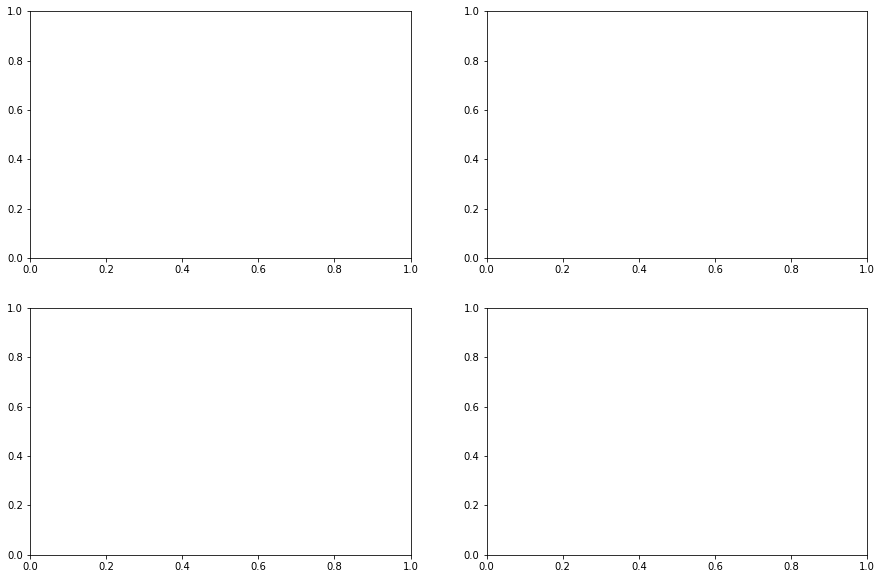

In [441]:
x = np.linspace(0,1,N_time)

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(15,10))


for i in range(50):
    ax[0,0].plot(x, X[i])
    ax[0,1].plot(x, Y[i])
    ax[1,0].plot(x, ALPHA[i])

ax[0,1].set_title('Y')
ax[0,1].set_ylabel('Y(t)')
ax[0,1].set_xlabel('t')
ax[0,0].set_title('X')
ax[0,0].set_ylabel('X(t)')
ax[0,0].set_xlabel('t')

ax[1,0].set_title('ALPHA(t)')
ax[1,0].set_ylabel('ALPHA')
ax[1,0].set_xlabel('t')
ax[1,1].plot(np.arange(len(J)), J)
ax[1,1].plot(np.arange(len(J)), np.full((len(J)),J[-1]))
ax[1,1].set_title('J')
ax[1,1].set_ylabel('J(t)')
ax[1,1].set_xlabel('t')

In [457]:
X_try = X[0,:]
W_try = W[0,:]
alpha_try = alphas[0,:]
dt = 1/ len(X_try)


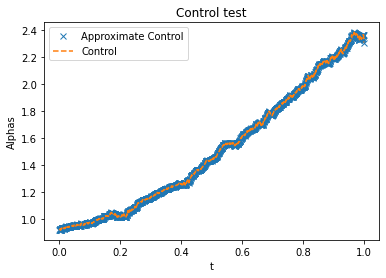

In [452]:
t = np.linspace(0, 1, N_time)
dt = 1/N_time

plt.plot(t, alphas[0,:], "x")
plt.plot(t, Y[0,:]/2, "--")
plt.title('Control test')
plt.xlabel('t')
plt.ylabel('Alphas')
plt.legend(['Approximate Control', 'Control'])

In [415]:
N = 10
dt = T/(N-1)
time_steps = np.linspace(0,T,N, endpoint=True) # time_steps 
N_mc = 3
J_list = []
gain = float('-inf')# big negative number
# ===== Generate sample paths for GBm ================ #  
dW = np.sqrt(dt) * np.random.randn(N_mc,N-1)
W_paths = np.zeros((N_mc, N))
W_paths[:, 1:] = np.cumsum(dW, axis=1)

x = np.zeros((N_mc, N))
y = np.zeros((N_mc, N))
z = np.zeros([N_mc,N])
alpha = np.zeros((N_mc, N))

#Solve Forward SDE
for i in range(N-1):
    x[:,i+1] = x[:,i] + dt * b_(x[:,i],time_steps[i],alpha[:,i]) + sigma(x[:,i],time_steps[i], alpha[:,i]) * dW[:,i]

#Solve BSDE
y[:,-1] = dg_by_dx(x[:,-1],time_steps[-1]) #2

for i in range(N-2,-1,-1):
    # get coeffs for Z conditioning on W[t] 
    coef_Z = coeffsForCondiExp(W_paths[:,i],y[:,i+1] * (W_paths[:,i+1]-W_paths[:,i]),hermite_order)     
    # Calc Z
    Z_hat = approxCondExp(W_paths[:,i],coef_Z) * (1/dt)
    z[:,i] = Z_hat
   
    g = dHam_by_dx(x[:,i], y[:,i], time_steps[i],alpha[:,i])
    # get coeffs for Y
    coef_Y =  coeffsForCondiExp(W_paths[:,i],y[:,i+1] + g * dt,hermite_order)
    # Calc Y
    Y_hat = approxCondExp(W_paths[:,i],coef_Y)
    y[:,i] = Y_hat

#solve for max alpha

for i in range(N):
    alpha[:,i] = alpha[:,i] + delta * dHam_by_da(y[:,i],x[:,i],time_steps[i],alpha[:,i] ) 

#calculate the gain by the integral using euler method 
current_gain = 0
for i in range(N):
    current_gain = current_gain + dt * f(x[:,i],time_steps[i],alpha[:,i])

current_gain = np.mean(current_gain + final_reward(x[:,N-1],time_steps[i]))
current_gain

J_list.append(current_gain)

# conditions for gain stability
if current_gain < gain:
    print('Method Failed')
    #return 0,0,0,0,0,0 
    #break
elif gain + epsilon > current_gain:
    print("Method converged")
    #return J_list,current_gain, iteration, x,y,alpha
    
    #break
else: #go to next iteration
    gain = current_gain

gain



/shared-libs/python3.7/py/lib/python3.7/site-packages/numpy/polynomial/hermite_e.py:1385: RankWarning: The fit may be poorly conditioned
  return pu._fit(hermevander, x, y, deg, rcond, full, w)


-25.808168853485455

In [416]:
J_list
alpha
y

array([[10.15320459, 10.32763342, 10.32763342, 10.32763342, 10.32763342,
        10.32763342, 10.32763342, 10.32763342, 10.32763342, 10.32763342],
       [10.15320459, 10.42104567, 10.42104567, 10.42104567, 10.42104567,
        10.42104567, 10.42104567, 10.42104567, 10.42104567, 10.42104567],
       [10.15320459,  9.71093467,  9.71093467,  9.71093467,  9.71093467,
         9.71093467,  9.71093467,  9.71093467,  9.71093467,  9.71093467]])

In [ ]:
#calculate the gain by the integral using euler method 
current_gain = 0
for i in range(N):
    current_gain = current_gain + dt * f(x[i],time_steps[i],alpha[i])

current_gain = current_gain + final_reward(x[N-1],time_steps[N-1])
#print(current_gain)
J_list.append(current_gain)

# conditions for gain stability
if current_gain < gain:
    print('Method Failed')
    return 0,0,0,0,0,0 
    #break
elif gain + epsilon > current_gain:
    print("Method converged")
    return J_list,current_gain, iteration, x,y,alpha
    
    break
else: #go to next iteration
    gain = current_gain

iteration = iteration + 1


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f035995c-05fa-4d78-a3eb-ad35f9416ab7' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>